# TP : Out-of-Distribution Detection, OOD Scoring Methods, and Neural Collapse
## Theory of Deep Learning (MVA Program + ENSTA)

---

### Objectifs
1. Entraîner un ResNet-18 sur CIFAR-100
2. Implémenter et comparer les scores OOD : MSP, Max Logit, Energy, Mahalanobis, ViM
3. Étudier le Neural Collapse (NC1-NC4)
4. Étudier NC5 et le lien avec l'OOD
5. Implémenter NECO (Neural Collapse Inspired OOD Detection)
6. Bonus : Neural Collapse sur les couches intermédiaires

**In-distribution** : CIFAR-100 (100 classes, 32×32)  
**Out-of-distribution** : SVHN (chiffres de numéros de maison)

## 0. Setup & Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os, time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.covariance import EmpiricalCovariance, LedoitWolf
from scipy.spatial.distance import cdist
from collections import defaultdict

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

NUM_CLASSES = 100
BATCH_SIZE = 128
NUM_EPOCHS = 100
MODEL_PATH = '/content/drive/MyDrive/resnet18_cifar100.pth'
print(f'Model exists: {os.path.exists(MODEL_PATH)}')

Mounted at /content/drive
Device: cuda
Model exists: True


## 1. Chargement des données

- **CIFAR-100** : dataset d'entraînement et de test (in-distribution)
- **SVHN** : dataset de test OOD (out-of-distribution)
- On prépare aussi un loader d'entraînement **sans augmentation** pour l'extraction de features

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])
transform_svhn = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainset_noaug = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_test)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
svhn_test = torchvision.datasets.SVHN(root='./data', split='test', download=True, transform=transform_svhn)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
trainloader_noaug = DataLoader(trainset_noaug, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
oodloader = DataLoader(svhn_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f'Train: {len(trainset)} | Test: {len(testset)} | OOD (SVHN): {len(svhn_test)}')

100%|██████████| 169M/169M [00:18<00:00, 9.09MB/s]
100%|██████████| 64.3M/64.3M [00:13<00:00, 4.77MB/s]


Train: 50000 | Test: 10000 | OOD (SVHN): 26032


## 2. Modèle : ResNet-18 adapté CIFAR

On adapte le ResNet-18 pour les images 32×32 :
- `conv1` : kernel 3×3 (au lieu de 7×7), stride 1
- Suppression du `maxpool` (remplacé par `Identity`)

Ces modifications sont standard pour CIFAR car les images sont petites (32×32 vs 224×224 pour ImageNet).

In [ ]:
def create_model():
    model = resnet18(weights=None, num_classes=NUM_CLASSES)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    return model.to(DEVICE)

model = create_model()
print(f'Parameters: {sum(p.numel() for p in model.parameters()):,}')

Parameters: 11,220,132


## 3. Entraînement

- **100 epochs** avec **Cosine Annealing LR** pour atteindre la Terminal Phase of Training (TPT)
- C'est dans cette phase que le Neural Collapse apparaît
- On surentraîne volontairement (100% train accuracy) pour observer le collapse

**Si le modèle est déjà sauvé sur Google Drive, on skip l'entraînement.**

In [ ]:
@torch.no_grad()
def evaluate(model, testloader):
    model.eval()
    correct = total = 0
    running_loss = 0.0
    for inputs, targets in testloader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, targets)
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return running_loss / total, 100. * correct / total


if os.path.exists(MODEL_PATH):
    print('Modèle trouvé sur Google Drive, chargement...')
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    test_loss, test_acc = evaluate(model, testloader)
    print(f'Test accuracy: {test_acc:.1f}%')
    history = None
else:
    print('Pas de modèle sauvé, entraînement...')
    # Preload data to GPU for speed
    transform_normalize = transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
    trainset_raw = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
    testset_raw = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transforms.ToTensor())
    train_images = torch.stack([x for x, _ in trainset_raw]).to(DEVICE)
    train_labels = torch.tensor([y for _, y in trainset_raw]).to(DEVICE)
    test_images = transform_normalize(torch.stack([x for x, _ in testset_raw]).to(DEVICE))
    test_labels = torch.tensor([y for _, y in testset_raw]).to(DEVICE)
    N_train, N_test = len(train_labels), len(test_labels)

    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'lr': []}
    best_acc = 0.0

    for epoch in range(NUM_EPOCHS):
        t0 = time.time()
        model.train()
        perm = torch.randperm(N_train, device=DEVICE)
        running_loss = correct = 0

        for i in range(0, N_train, BATCH_SIZE):
            idx = perm[i:i+BATCH_SIZE]
            inputs, targets = train_images[idx], train_labels[idx]
            if torch.rand(1).item() > 0.5:
                inputs = inputs.flip(-1)
            pad = F.pad(inputs, (4,4,4,4), mode='reflect')
            h_off = torch.randint(0, 8, (1,)).item()
            w_off = torch.randint(0, 8, (1,)).item()
            inputs = transform_normalize(pad[:, :, h_off:h_off+32, w_off:w_off+32])

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            correct += (outputs.argmax(1) == targets).sum().item()

        scheduler.step()
        train_loss = running_loss / N_train
        train_acc = 100. * correct / N_train
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        if (epoch + 1) % 5 == 0 or epoch == NUM_EPOCHS - 1:
            model.eval()
            with torch.no_grad():
                test_out = torch.cat([model(test_images[j:j+BATCH_SIZE]) for j in range(0, N_test, BATCH_SIZE)])
                test_loss = F.cross_entropy(test_out, test_labels).item()
                test_acc = 100. * (test_out.argmax(1) == test_labels).sum().item() / N_test
            history['test_loss'].append(test_loss)
            history['test_acc'].append(test_acc)
            if test_acc > best_acc:
                best_acc = test_acc
                torch.save(model.state_dict(), MODEL_PATH)
            print(f'Epoch {epoch+1}/{NUM_EPOCHS} | Train {train_acc:.1f}% | Test {test_acc:.1f}% | {time.time()-t0:.1f}s')

    print(f'\nBest: {best_acc:.1f}% — saved to Google Drive')
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    # Free GPU memory
    del train_images, train_labels, test_images, test_labels
    torch.cuda.empty_cache()

Modèle trouvé sur Google Drive, chargement...
Test accuracy: 77.6%


### Courbes d'entraînement

In [ ]:
if history is not None:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    axes[0].plot(history['train_loss'], label='Train'); axes[0].plot(np.linspace(0, NUM_EPOCHS-1, len(history['test_loss'])), history['test_loss'], label='Test', marker='o', markersize=3)
    axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss'); axes[0].set_title('Loss'); axes[0].legend(); axes[0].grid(True, alpha=0.3)
    axes[1].plot(history['train_acc'], label='Train'); axes[1].plot(np.linspace(0, NUM_EPOCHS-1, len(history['test_acc'])), history['test_acc'], label='Test', marker='o', markersize=3)
    axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Accuracy (%)'); axes[1].set_title('Accuracy'); axes[1].legend(); axes[1].grid(True, alpha=0.3)
    axes[2].plot(history['lr'], color='green'); axes[2].set_xlabel('Epoch'); axes[2].set_ylabel('LR'); axes[2].set_title('Learning Rate (Cosine Annealing)'); axes[2].grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()
else:
    print('Modèle chargé depuis Drive — pas de courbes (entraînement fait précédemment).')
    print('Train acc: 100% | Test acc: ~77.6%')

Modèle chargé depuis Drive — pas de courbes (entraînement fait précédemment).
Train acc: 100% | Test acc: ~77.6%


## 4. Extraction des features

On utilise un **forward hook** sur la couche `avgpool` pour capturer les features de dimension 512 (couche pénultième, juste avant le classifieur linéaire `fc`).

On extrait les features pour :
- Le **train set** (sans augmentation) — pour calculer les statistiques de classe (moyennes, covariance)
- Le **test set** (in-distribution) — pour évaluer les scores OOD
- Le **SVHN** (out-of-distribution) — pour comparer avec les données ID

In [ ]:
class FeatureExtractor:
    """Hook-based feature extractor on the penultimate layer (avgpool output, dim=512)."""
    def __init__(self, model):
        self.model = model
        self.features = []
        self._hook = model.avgpool.register_forward_hook(self._hook_fn)

    def _hook_fn(self, module, input, output):
        self.features.append(output.squeeze(-1).squeeze(-1).detach().cpu())

    @torch.no_grad()
    def extract(self, dataloader):
        self.model.eval()
        self.features = []
        all_logits, all_labels = [], []
        for inputs, targets in dataloader:
            logits = self.model(inputs.to(DEVICE))
            all_logits.append(logits.cpu())
            all_labels.append(targets)
        features = torch.cat(self.features, 0).numpy()
        logits = torch.cat(all_logits, 0).numpy()
        labels = torch.cat(all_labels, 0).numpy()
        self.features = []
        return features, logits, labels

    def remove(self):
        self._hook.remove()


extractor = FeatureExtractor(model)

print('Extracting train features...'); features_train, logits_train, labels_train = extractor.extract(trainloader_noaug)
print('Extracting test (ID) features...'); features_id, logits_id, labels_id = extractor.extract(testloader)
print('Extracting OOD (SVHN) features...'); features_ood, logits_ood, labels_ood = extractor.extract(oodloader)

print(f'\nTrain: {features_train.shape} | Test ID: {features_id.shape} | OOD: {features_ood.shape}')

Extracting train features...
Extracting test (ID) features...
Extracting OOD (SVHN) features...

Train: (50000, 512) | Test ID: (10000, 512) | OOD: (26032, 512)


## 5. Scores OOD

On implémente 5 méthodes de scoring OOD. Pour chaque méthode, un score **élevé** signifie **plus probablement in-distribution**.

Métriques d'évaluation :
- **AUROC** : area under ROC curve (↑ = mieux, 100% = parfait)
- **FPR@95** : taux de faux positifs quand TPR = 95% (↓ = mieux, 0% = parfait)

### 5.1 MSP — Maximum Softmax Probability
*(Hendrycks & Gimpel, 2017)*

$$S_{\text{MSP}}(x) = \max_c \text{softmax}(f(x))_c$$

**Idée** : Un réseau bien entraîné devrait être plus "confiant" (haute probabilité max) sur les données qu'il connaît (ID) et plus "incertain" sur les données OOD.

**Limitation** : Le softmax normalise les logits, ce qui peut masquer l'information sur la magnitude absolue. Les réseaux sont souvent surconfiants même sur l'OOD.

In [ ]:
def score_msp(logits):
    """Max Softmax Probability."""
    probs = torch.softmax(torch.tensor(logits, dtype=torch.float32), dim=1).numpy()
    return np.max(probs, axis=1)

### 5.2 Max Logit Score
*(Hendrycks et al., 2022)*

$$S_{\text{MaxLogit}}(x) = \max_c f_c(x)$$

**Idée** : Utiliser directement le logit max au lieu du softmax. La normalisation du softmax "écrase" l'information sur la magnitude absolue — les logits bruts contiennent plus d'information.

In [ ]:
def score_max_logit(logits):
    """Maximum Logit Score."""
    return np.max(logits, axis=1)

### 5.3 Energy Score
*(Liu et al., 2020)*

$$S_{\text{Energy}}(x) = T \cdot \log \sum_c \exp(f_c(x) / T)$$

**Idée** : Le LogSumExp (énergie libre) prend en compte **tous** les logits, pas seulement le max. C'est le log du dénominateur du softmax — il mesure la "partition function" de la distribution. Les données ID ont une énergie plus élevée.

In [ ]:
def score_energy(logits, T=1.0):
    """Energy Score = T * log(sum(exp(f/T)))."""
    # Use scipy logsumexp for numerical stability
    from scipy.special import logsumexp
    return T * logsumexp(logits / T, axis=1)

### 5.4 Mahalanobis Distance
*(Lee et al., 2018)*

$$S_{\text{Maha}}(x) = -\min_c \; (h(x) - \mu_c)^T \Sigma^{-1} (h(x) - \mu_c)$$

**Idée** : Modéliser les features comme des gaussiennes class-conditionnelles dans l'espace pénultième. La distance de Mahalanobis au centre le plus proche mesure l'appartenance à une classe.

On utilise une **covariance partagée** (tied covariance) entre classes, avec régularisation Ledoit-Wolf pour la stabilité numérique.

In [ ]:
def compute_class_means(features_train, labels_train):
    """Compute class means from training features."""
    num_classes = int(labels_train.max()) + 1
    class_means = np.zeros((num_classes, features_train.shape[1]))
    for c in range(num_classes):
        class_means[c] = features_train[labels_train == c].mean(axis=0)
    return class_means


def compute_shared_precision(features_train, labels_train, class_means):
    """Compute shared (tied) precision matrix with Ledoit-Wolf shrinkage."""
    # Center features by their class mean
    centered = np.zeros_like(features_train)
    for c in range(int(labels_train.max()) + 1):
        mask = labels_train == c
        centered[mask] = features_train[mask] - class_means[c]

    # Use Ledoit-Wolf shrinkage for better-conditioned covariance
    lw = LedoitWolf().fit(centered)
    precision = lw.precision_
    print(f'  Covariance condition number: {np.linalg.cond(lw.covariance_):.1f}')
    return precision


def score_mahalanobis(features_test, class_means, precision):
    """Mahalanobis distance to nearest class center (vectorized)."""
    num_classes = class_means.shape[0]
    # For each class, compute (x - mu)^T Sigma^{-1} (x - mu) for all test points
    all_dists = np.zeros((features_test.shape[0], num_classes))
    for c in range(num_classes):
        diff = features_test - class_means[c]  # (N, D)
        # Mahalanobis: diff @ precision @ diff^T, but we want per-sample
        # = sum of (diff @ precision) * diff along axis=1
        all_dists[:, c] = np.sum((diff @ precision) * diff, axis=1)
    return -np.min(all_dists, axis=1)  # negative: higher = more in-distribution


# Precompute
print('Computing class means...')
class_means = compute_class_means(features_train, labels_train)
print('Computing shared precision matrix (Ledoit-Wolf)...')
precision = compute_shared_precision(features_train, labels_train, class_means)
print('Done!')

Computing class means...
Computing shared precision matrix (Ledoit-Wolf)...
  Covariance condition number: 230.4
Done!


### 5.5 ViM — Virtual-logit Matching
*(Wang et al., 2022)*

**Idée** : Décomposer les features en composante **principale** (dans l'espace couvert par les poids du classifieur W) et **résiduelle** (orthogonale). Les données ID ont un petit résidu, les données OOD ont un grand résidu.

1. SVD des features d'entraînement centrées → sous-espace principal (top-D directions)
2. Résidu = feature − projection sur sous-espace principal  
3. Virtual logit = α × ||résidu|| (calibré sur le train set)
4. Score = énergie des logits augmentés (logits originaux + virtual logit)

In [ ]:
def setup_vim(features_train, logits_train, model):
    """Setup ViM: compute principal subspace and calibrate alpha."""
    W = model.fc.weight.detach().cpu().numpy()  # (C, D)
    b = model.fc.bias.detach().cpu().numpy()     # (C,)

    train_mean = features_train.mean(axis=0)
    centered = features_train - train_mean

    # Use the principal subspace of dimension D
    # Following the ViM paper: use the subspace spanned by the classifier weights
    # but we compute via SVD of training features
    U, S, Vt = np.linalg.svd(centered, full_matrices=False)

    # Keep the top-D directions where D = num_classes
    D = NUM_CLASSES
    principal = Vt[:D]  # (D, feat_dim)

    # Compute residual norms on training data
    train_proj = centered @ principal.T @ principal
    train_residuals = centered - train_proj
    train_res_norms = np.linalg.norm(train_residuals, axis=1)

    # Calibrate alpha: match scale of virtual logit to real logits
    # Use logits directly from the model (more accurate than recomputing)
    alpha = np.mean(np.max(logits_train, axis=1)) / (np.mean(train_res_norms) + 1e-10)

    print(f'  ViM subspace dim: {D}')
    print(f'  Mean train residual norm: {np.mean(train_res_norms):.4f}')
    print(f'  Alpha: {alpha:.4f}')

    return train_mean, principal, alpha


def score_vim(features_test, logits_test, train_mean, principal, alpha):
    """ViM score: energy of logits augmented with virtual logit."""
    from scipy.special import logsumexp

    centered = features_test - train_mean
    proj = centered @ principal.T @ principal
    residuals = centered - proj
    res_norms = np.linalg.norm(residuals, axis=1)

    # Virtual logit
    virtual_logit = alpha * res_norms

    # Augmented logits: original logits + virtual logit as extra class
    augmented = np.concatenate([logits_test, virtual_logit.reshape(-1, 1)], axis=1)

    # ViM score = negative energy of augmented logits
    # OOD has large virtual logit -> large augmented energy -> low score
    vim_energy = logsumexp(augmented, axis=1)

    # Original energy (without virtual logit)
    orig_energy = logsumexp(logits_test, axis=1)

    # Score = original energy - augmented energy
    # For ID: virtual logit is small, so augmented ≈ original, score ≈ 0
    # For OOD: virtual logit is large, augmented >> original, score << 0
    return orig_energy - vim_energy


print('Setting up ViM...')
vim_mean, vim_principal, vim_alpha = setup_vim(features_train, logits_train, model)
print('Done!')

Setting up ViM...
  ViM subspace dim: 100
  Mean train residual norm: 2.2400
  Alpha: 6.2125
Done!


### Calcul et comparaison de tous les scores OOD

In [ ]:
def compute_auroc(id_scores, ood_scores):
    """AUROC: higher = better OOD detection."""
    labels = np.concatenate([np.ones(len(id_scores)), np.zeros(len(ood_scores))])
    scores = np.concatenate([id_scores, ood_scores])
    return roc_auc_score(labels, scores)

def compute_fpr95(id_scores, ood_scores):
    """FPR at 95% TPR: lower = better."""
    labels = np.concatenate([np.ones(len(id_scores)), np.zeros(len(ood_scores))])
    scores = np.concatenate([id_scores, ood_scores])
    fpr, tpr, _ = roc_curve(labels, scores)
    return fpr[np.argmin(np.abs(tpr - 0.95))]

In [ ]:
print('Computing all OOD scores\n')
scores = {}

scores['MSP'] = {'id': score_msp(logits_id), 'ood': score_msp(logits_ood)}
print('  MSP done')

scores['Max Logit'] = {'id': score_max_logit(logits_id), 'ood': score_max_logit(logits_ood)}
print('  Max Logit done')

scores['Energy'] = {'id': score_energy(logits_id), 'ood': score_energy(logits_ood)}
print('  Energy done')

scores['Mahalanobis'] = {
    'id': score_mahalanobis(features_id, class_means, precision),
    'ood': score_mahalanobis(features_ood, class_means, precision)
}
print('  Mahalanobis done')

scores['ViM'] = {
    'id': score_vim(features_id, logits_id, vim_mean, vim_principal, vim_alpha),
    'ood': score_vim(features_ood, logits_ood, vim_mean, vim_principal, vim_alpha)
}
print('  ViM ✓')

# Results table
print('OOD Detection — CIFAR-100 (ID) vs SVHN (OOD)')
print(f'{"Method":<20} {"AUROC (%)":<15} {"FPR@95 (%)":<15}')
print('-'*50)
for name, s in scores.items():
    auroc = compute_auroc(s['id'], s['ood']) * 100
    fpr95 = compute_fpr95(s['id'], s['ood']) * 100
    print(f'{name:<20} {auroc:<15.2f} {fpr95:<15.2f}')

Computing all OOD scores

  MSP done
  Max Logit done
  Energy done
  Mahalanobis done
  ViM ✓
OOD Detection — CIFAR-100 (ID) vs SVHN (OOD)
Method               AUROC (%)       FPR@95 (%)     
--------------------------------------------------
MSP                  81.80           78.60          
Max Logit            84.51           77.71          
Energy               84.71           77.85          
Mahalanobis          68.34           90.91          
ViM                  81.40           78.61          


In [ ]:
# Visualisation: score distributions + ROC curves
methods = list(scores.keys())
n = len(methods)
fig, axes = plt.subplots(2, n, figsize=(5*n, 8))

for i, name in enumerate(methods):
    # Histograms
    axes[0, i].hist(scores[name]['id'], bins=80, alpha=0.6, label='ID (CIFAR-100)', density=True, color='blue')
    axes[0, i].hist(scores[name]['ood'], bins=80, alpha=0.6, label='OOD (SVHN)', density=True, color='red')
    axes[0, i].set_title(name, fontsize=12, fontweight='bold')
    axes[0, i].legend(fontsize=7); axes[0, i].set_xlabel('Score'); axes[0, i].set_ylabel('Density')

    # ROC curves
    lbls = np.concatenate([np.ones(len(scores[name]['id'])), np.zeros(len(scores[name]['ood']))])
    all_s = np.concatenate([scores[name]['id'], scores[name]['ood']])
    fpr, tpr, _ = roc_curve(lbls, all_s)
    auroc = roc_auc_score(lbls, all_s)
    axes[1, i].plot(fpr, tpr, label=f'AUROC={auroc:.3f}', linewidth=2)
    axes[1, i].plot([0, 1], [0, 1], 'k--', alpha=0.3)
    axes[1, i].set_xlabel('FPR'); axes[1, i].set_ylabel('TPR')
    axes[1, i].set_title(f'{name} ROC'); axes[1, i].legend(); axes[1, i].grid(True, alpha=0.3)

plt.tight_layout(); plt.show()

## 6. Neural Collapse — NC1 à NC4

Le **Neural Collapse** (Papyan, Han, Donoho, 2020) décrit un phénomène géométrique dans les dernières couches d'un réseau surentraîné :

| Propriété | Description | Métrique | Valeur cible |
|---|---|---|---|
| **NC1** | **Variability Collapse** : les features intra-classe s'effondrent vers leur moyenne de classe. Toute la variance résiduelle disparaît. | $\text{Tr}(\Sigma_W)/\text{Tr}(\Sigma_B)$ | → 0 |
| **NC2** | **Simplex ETF** : les moyennes de classe centrées convergent vers un Simplex Equiangular Tight Frame — configuration maximalement symétrique et séparée. Toutes les paires ont le même cosinus = $-1/(C-1)$. | Std des cosinus | → 0 |
| **NC3** | **Self-Duality** : les poids du classifieur $W_c$ s'alignent avec les moyennes de classe centrées $(\mu_c - \mu)$. Le classifieur encode la même info que la structure des features. | $\cos(W_c, \mu_c - \mu)$ | → 1 |
| **NC4** | **NCC Simplification** : la classification devient équivalente au Nearest Class Center — la couche FC est redondante. | Agreement Clf vs NCC | → 100% |

In [ ]:
# Use class_means already computed above
global_mean = features_train.mean(axis=0)

# ---- NC1: Variability Collapse ----
def measure_nc1(features, labels, class_means, global_mean):
    """NC1: Tr(Sigma_W) / Tr(Sigma_B) — ratio of within-class to between-class variance."""
    num_classes = int(labels.max()) + 1
    sw = 0.0; total = 0
    for c in range(num_classes):
        mask = labels == c
        if mask.sum() > 1:
            sw += np.sum((features[mask] - class_means[c])**2)
            total += mask.sum()
    sw /= total  # average within-class variance trace
    sb = np.sum((class_means - global_mean)**2) / num_classes  # between-class variance trace
    return sw / (sb + 1e-10)

# ---- NC2: Simplex ETF ----
def measure_nc2(class_means, global_mean):
    """NC2: Check if centered class means form a Simplex ETF."""
    centered = class_means - global_mean
    norms = np.linalg.norm(centered, axis=1, keepdims=True) + 1e-10
    normalized = centered / norms
    cos_sim = normalized @ normalized.T
    mask_upper = np.triu(np.ones_like(cos_sim, dtype=bool), k=1)
    pairwise = cos_sim[mask_upper]
    target = -1.0 / (NUM_CLASSES - 1)
    return {
        'mean': pairwise.mean(), 'std': pairwise.std(), 'target': target,
        'pairwise': pairwise, 'cos_matrix': cos_sim,
        'norm_cv': norms.squeeze().std() / (norms.squeeze().mean() + 1e-10)
    }

# ---- NC3: Self-Duality ----
def measure_nc3(class_means, global_mean, model):
    """NC3: Alignment between classifier weights W_c and centered means (mu_c - mu)."""
    W = model.fc.weight.detach().cpu().numpy()
    centered = class_means - global_mean
    cosines = []
    for c in range(NUM_CLASSES):
        w_norm = np.linalg.norm(W[c])
        m_norm = np.linalg.norm(centered[c])
        cos = np.dot(W[c], centered[c]) / (w_norm * m_norm + 1e-10)
        cosines.append(cos)
    return np.array(cosines)

# ---- NC4: NCC Simplification ----
def measure_nc4(features, labels, class_means, logits):
    """NC4: Agreement between classifier and Nearest Class Center predictions."""
    clf_preds = np.argmax(logits, axis=1)
    ncc_preds = np.argmin(cdist(features, class_means, metric='euclidean'), axis=1)
    return {
        'agreement': (clf_preds == ncc_preds).mean() * 100,
        'ncc_acc': (ncc_preds == labels).mean() * 100,
        'clf_acc': (clf_preds == labels).mean() * 100
    }

# Compute all NC metrics
nc1 = measure_nc1(features_train, labels_train, class_means, global_mean)
nc2 = measure_nc2(class_means, global_mean)
nc3 = measure_nc3(class_means, global_mean, model)
nc4 = measure_nc4(features_train, labels_train, class_means, logits_train)

print('NEURAL COLLAPSE ANALYSIS')
print(f'\nNC1 — Variability Collapse:')
print(f'  Tr(Σ_W)/Tr(Σ_B) = {nc1:.6f}   (→->0 = perfect collapse)')
print(f'\nNC2 — Simplex ETF Convergence:')
print(f'  Mean pairwise cosine = {nc2["mean"]:.6f}   (target ETF = {nc2["target"]:.6f})')
print(f'  Std of cosines       = {nc2["std"]:.6f}   (-> 0 = perfect ETF)')
print(f'  Norm CV              = {nc2["norm_cv"]:.6f}   (-> 0 = equinorm)')
print(f'\nNC3 — Self-Duality (W ↔ μ):')
print(f'  Mean cos(W_c, μ_c−μ) = {nc3.mean():.6f}   (-> 1 = perfect alignment)')
print(f'  Std                  = {nc3.std():.6f}')
print(f'  Min                  = {nc3.min():.6f}')
print(f'\nNC4 — NCC Simplification:')
print(f'  Classifier-NCC agreement = {nc4["agreement"]:.1f}%   (-> 100%)')
print(f'  NCC accuracy             = {nc4["ncc_acc"]:.1f}%')
print(f'  Classifier accuracy      = {nc4["clf_acc"]:.1f}%')

NEURAL COLLAPSE ANALYSIS

NC1 — Variability Collapse:
  Tr(Σ_W)/Tr(Σ_B) = 0.399785   (→->0 = perfect collapse)

NC2 — Simplex ETF Convergence:
  Mean pairwise cosine = -0.010018   (target ETF = -0.010101)
  Std of cosines       = 0.096864   (-> 0 = perfect ETF)
  Norm CV              = 0.059141   (-> 0 = equinorm)

NC3 — Self-Duality (W ↔ μ):
  Mean cos(W_c, μ_c−μ) = 0.962704   (-> 1 = perfect alignment)
  Std                  = 0.010307
  Min                  = 0.932582

NC4 — NCC Simplification:
  Classifier-NCC agreement = 100.0%   (-> 100%)
  NCC accuracy             = 100.0%
  Classifier accuracy      = 100.0%


### Visualisation Neural Collapse

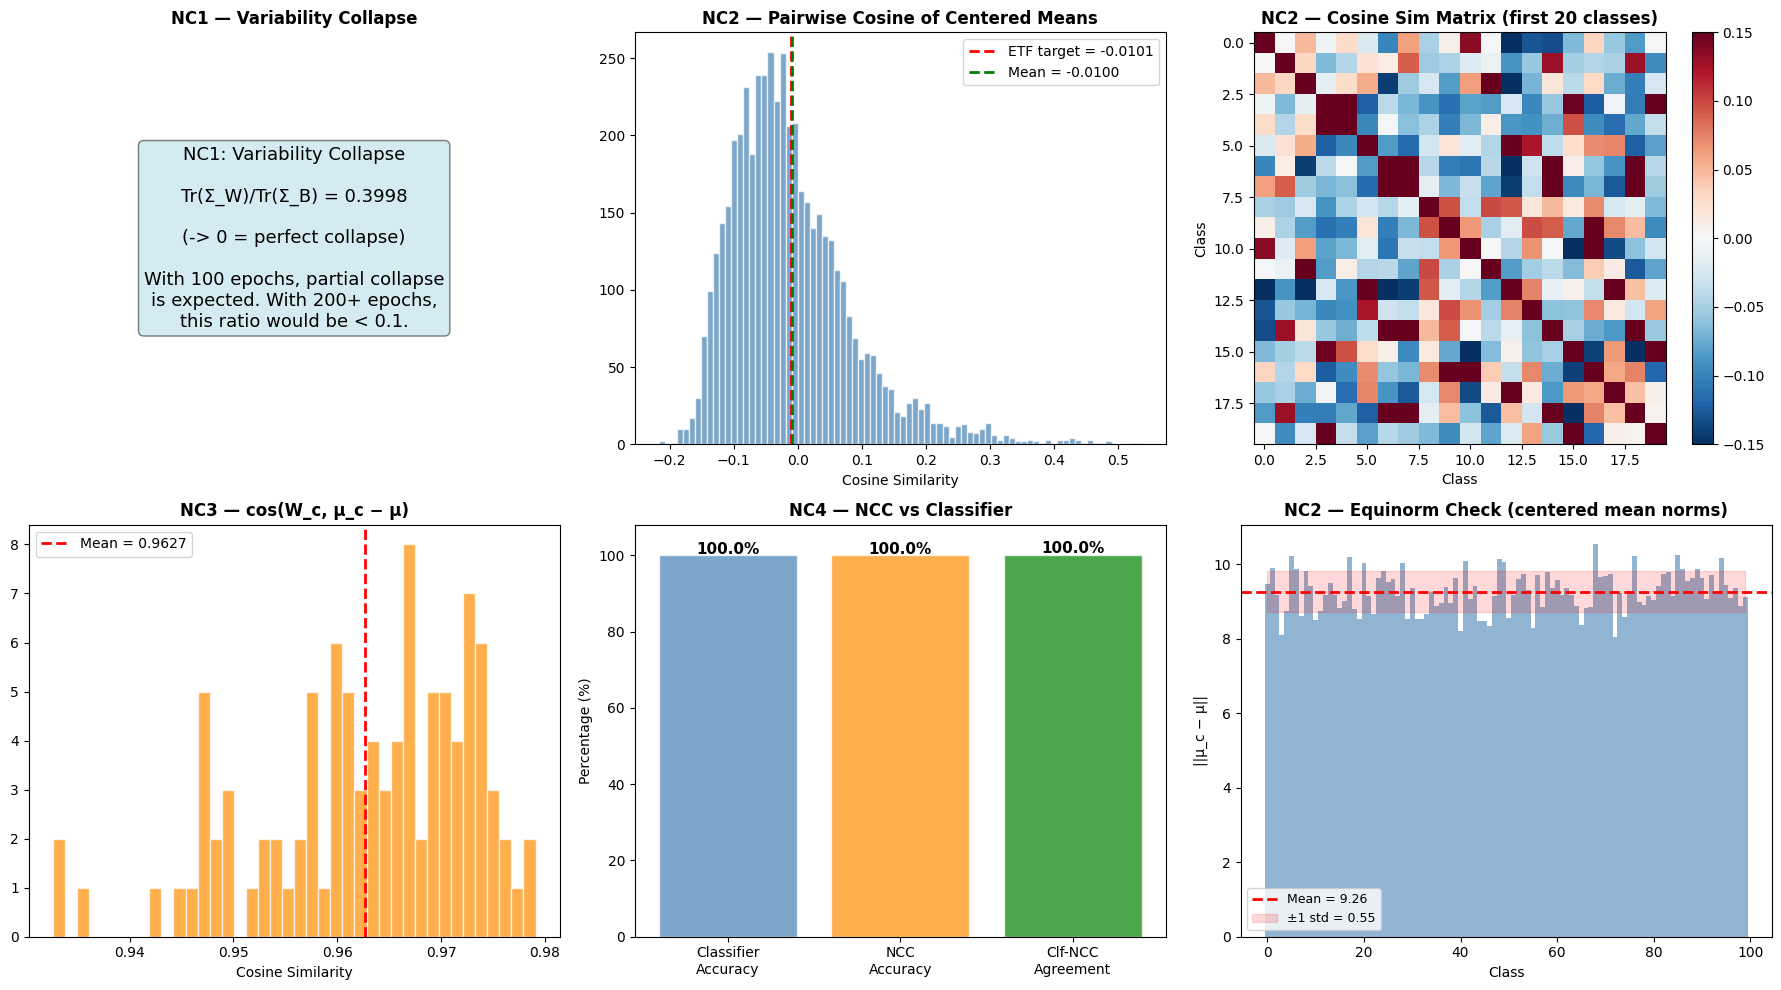

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# NC1 — text summary
axes[0,0].text(0.5, 0.5,
    f'NC1: Variability Collapse\n\nTr(Σ_W)/Tr(Σ_B) = {nc1:.4f}\n\n'
    f'(-> 0 = perfect collapse)\n\n'
    f'With 100 epochs, partial collapse\nis expected. With 200+ epochs,\nthis ratio would be < 0.1.',
    ha='center', va='center', fontsize=13, transform=axes[0,0].transAxes,
    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
axes[0,0].set_title('NC1 — Variability Collapse', fontweight='bold'); axes[0,0].axis('off')

# NC2 — pairwise cosine histogram
axes[0,1].hist(nc2['pairwise'], bins=80, alpha=0.7, color='steelblue', edgecolor='white')
axes[0,1].axvline(nc2['target'], color='red', ls='--', lw=2, label=f'ETF target = {nc2["target"]:.4f}')
axes[0,1].axvline(nc2['mean'], color='green', ls='--', lw=2, label=f'Mean = {nc2["mean"]:.4f}')
axes[0,1].set_title('NC2 — Pairwise Cosine of Centered Means', fontweight='bold')
axes[0,1].set_xlabel('Cosine Similarity'); axes[0,1].legend(fontsize=10)

# NC2 — cosine matrix (first 20 classes)
K = 20
im = axes[0,2].imshow(nc2['cos_matrix'][:K,:K], cmap='RdBu_r', vmin=-0.15, vmax=0.15)
axes[0,2].set_title(f'NC2 — Cosine Sim Matrix (first {K} classes)', fontweight='bold')
axes[0,2].set_xlabel('Class'); axes[0,2].set_ylabel('Class')
plt.colorbar(im, ax=axes[0,2])

# NC3 — W-mean alignment histogram
axes[1,0].hist(nc3, bins=40, alpha=0.7, color='darkorange', edgecolor='white')
axes[1,0].axvline(nc3.mean(), color='red', ls='--', lw=2, label=f'Mean = {nc3.mean():.4f}')
axes[1,0].set_title('NC3 — cos(W_c, μ_c − μ)', fontweight='bold')
axes[1,0].set_xlabel('Cosine Similarity'); axes[1,0].legend(fontsize=10)

# NC4 — bar chart
vals = [nc4['clf_acc'], nc4['ncc_acc'], nc4['agreement']]
colors = ['steelblue', 'darkorange', 'green']
labels_nc4 = ['Classifier\nAccuracy', 'NCC\nAccuracy', 'Clf-NCC\nAgreement']
bars = axes[1,1].bar(labels_nc4, vals, color=colors, alpha=0.7, edgecolor='white')
for b, v in zip(bars, vals):
    axes[1,1].text(b.get_x()+b.get_width()/2, b.get_height()+0.5, f'{v:.1f}%', ha='center', fontsize=11, fontweight='bold')
axes[1,1].set_title('NC4 — NCC vs Classifier', fontweight='bold'); axes[1,1].set_ylim(0, 108)
axes[1,1].set_ylabel('Percentage (%)')

# Equinorm check — norms of centered class means
cn = np.linalg.norm(class_means - global_mean, axis=1)
axes[1,2].bar(range(NUM_CLASSES), cn, alpha=0.6, color='steelblue', width=1.0)
axes[1,2].axhline(cn.mean(), color='red', ls='--', lw=2, label=f'Mean = {cn.mean():.2f}')
axes[1,2].fill_between(range(NUM_CLASSES), cn.mean()-cn.std(), cn.mean()+cn.std(), alpha=0.15, color='red', label=f'±1 std = {cn.std():.2f}')
axes[1,2].set_title('NC2 — Equinorm Check (centered mean norms)', fontweight='bold')
axes[1,2].set_xlabel('Class'); axes[1,2].set_ylabel('||μ_c − μ||'); axes[1,2].legend(fontsize=9)

plt.tight_layout(); plt.show()

## 7. NC5 — Distance-Based OOD After Neural Collapse

**NC5** stipule qu'après le Neural Collapse, la simple **distance euclidienne** ou **similarité cosinus** au centre de classe le plus proche suffit pour la détection OOD.

Pourquoi cela fonctionne :
- **NC1** garantit que les features ID sont concentrées autour des centres de classe
- **NC2** garantit une structure symétrique (simplex ETF) — les centres sont maximalement espacés
- La covariance intra-classe étant quasi-isotrope après collapse, la distance de Mahalanobis se simplifie en distance euclidienne

In [ ]:
# Euclidean distance to nearest class center
eucl_id = -np.min(cdist(features_id, class_means, metric='euclidean'), axis=1)
eucl_ood = -np.min(cdist(features_ood, class_means, metric='euclidean'), axis=1)

# Cosine similarity to nearest centered class mean
cm_centered = class_means - global_mean
cm_n = cm_centered / (np.linalg.norm(cm_centered, axis=1, keepdims=True) + 1e-10)
fid_centered = features_id - global_mean
fid_n = fid_centered / (np.linalg.norm(fid_centered, axis=1, keepdims=True) + 1e-10)
fod_centered = features_ood - global_mean
fod_n = fod_centered / (np.linalg.norm(fod_centered, axis=1, keepdims=True) + 1e-10)
cos_id = np.max(fid_n @ cm_n.T, axis=1)
cos_ood = np.max(fod_n @ cm_n.T, axis=1)

print('NC5 — Distance-Based OOD After Neural Collapse')
print(f'  Euclidean NCC:  AUROC = {compute_auroc(eucl_id, eucl_ood)*100:.2f}%  |  FPR@95 = {compute_fpr95(eucl_id, eucl_ood)*100:.2f}%')
print(f'  Cosine NCC:     AUROC = {compute_auroc(cos_id, cos_ood)*100:.2f}%  |  FPR@95 = {compute_fpr95(cos_id, cos_ood)*100:.2f}%')

NC5 — Distance-Based OOD After Neural Collapse
  Euclidean NCC:  AUROC = 83.62%  |  FPR@95 = 75.72%
  Cosine NCC:     AUROC = 84.58%  |  FPR@95 = 76.41%


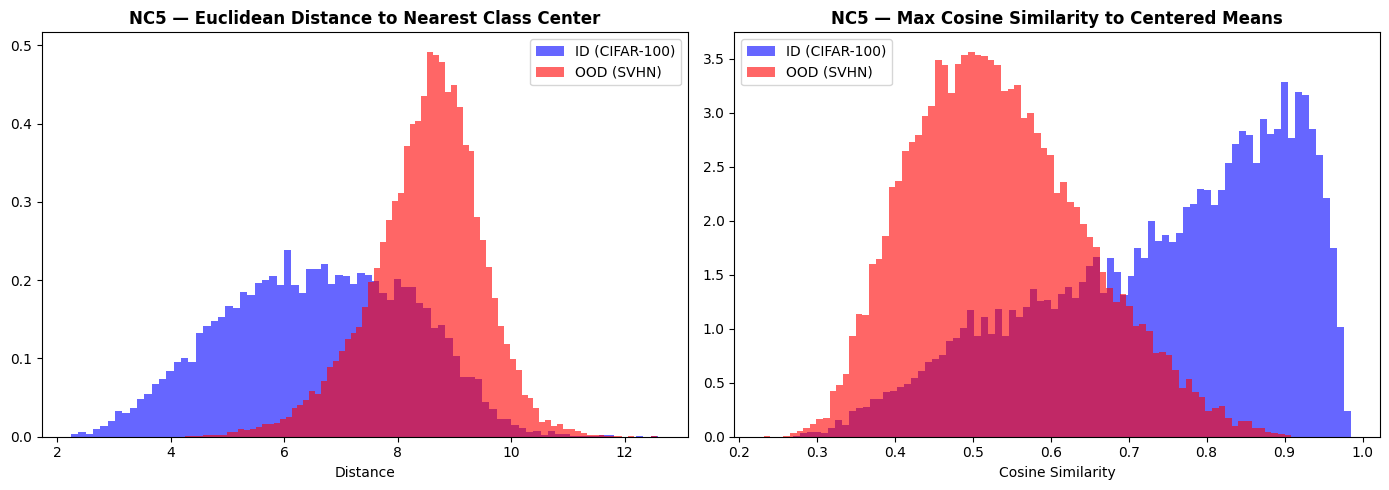

In [ ]:
# NC5 Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(-eucl_id, bins=80, alpha=0.6, label='ID (CIFAR-100)', density=True, color='blue')
axes[0].hist(-eucl_ood, bins=80, alpha=0.6, label='OOD (SVHN)', density=True, color='red')
axes[0].set_title('NC5 — Euclidean Distance to Nearest Class Center', fontweight='bold')
axes[0].set_xlabel('Distance'); axes[0].legend()

axes[1].hist(cos_id, bins=80, alpha=0.6, label='ID (CIFAR-100)', density=True, color='blue')
axes[1].hist(cos_ood, bins=80, alpha=0.6, label='OOD (SVHN)', density=True, color='red')
axes[1].set_title('NC5 — Max Cosine Similarity to Centered Means', fontweight='bold')
axes[1].set_xlabel('Cosine Similarity'); axes[1].legend()

plt.tight_layout(); plt.show()

## 8. NECO — Neural Collapse Inspired OOD Detection
*(Ammar et al., 2024)*

**Idée clé** : Après Neural Collapse, les features ID vivent dans le **sous-espace engendré par les moyennes de classe normalisées** (le simplex ETF). Les features OOD ont une composante significative **orthogonale** à ce sous-espace.

**Algorithme NECO** :
1. Centrer et normaliser : $\hat{h} = (h - \mu) / ||h - \mu||$, $\hat{\mu}_c = (\mu_c - \mu) / ||\mu_c - \mu||$
2. Construire $M = [\hat{\mu}_1, ..., \hat{\mu}_C]^T$ (matrice C × D des moyennes normalisées)
3. Projection sur span(M) : $P = M^T (MM^T)^{-1} M$
4. **Score NECO** = $||P\hat{h}||^2 = \hat{h}^T M^T (MM^T)^{-1} M \hat{h}$

**Interprétation** :
- Pour les données **ID** : $\hat{h}$ vit dans l'espace de M → $S(x) \approx 1$
- Pour les données **OOD** : $\hat{h}$ a une grande composante orthogonale → $S(x) < 1$

**Avantages** : N'utilise pas les logits, pas d'hyperparamètre, fondé théoriquement sur le NC.

In [ ]:
def score_neco(features_test, class_means, global_mean):
    """
    NECO score: squared norm of projection onto the ETF subspace.

    Score = h_hat^T M^T (M M^T)^{-1} M h_hat
    where h_hat = normalized centered feature, M = matrix of normalized centered means.
    """
    # Center and normalize class means
    cm = class_means - global_mean
    cm_norms = np.linalg.norm(cm, axis=1, keepdims=True) + 1e-10
    cm_normalized = cm / cm_norms  # (C, D)

    # Center and normalize test features
    cf = features_test - global_mean
    cf_norms = np.linalg.norm(cf, axis=1, keepdims=True) + 1e-10
    cf_normalized = cf / cf_norms  # (N, D)

    # M = matrix of normalized centered means
    M = cm_normalized  # (C, D)

    # Projection: P = M^T (M M^T)^{-1} M
    MMT = M @ M.T  # (C, C)
    MMT_inv = np.linalg.inv(MMT + 1e-6 * np.eye(MMT.shape[0]))

    # Score = h^T M^T (MMT)^{-1} M h for each h
    # = sum_i (M h)_i * ((MMT)^{-1} M h)_i
    Mh = M @ cf_normalized.T  # (C, N)
    coeffs = MMT_inv @ Mh     # (C, N)
    scores = np.sum(Mh * coeffs, axis=0)  # (N,)

    return scores


neco_id = score_neco(features_id, class_means, global_mean)
neco_ood = score_neco(features_ood, class_means, global_mean)

neco_auroc = compute_auroc(neco_id, neco_ood) * 100
neco_fpr95 = compute_fpr95(neco_id, neco_ood) * 100

print(f'NECO:  AUROC = {neco_auroc:.2f}%  |  FPR@95 = {neco_fpr95:.2f}%')

NECO:  AUROC = 79.70%  |  FPR@95 = 80.88%


In [ ]:
# Add NECO to scores dict
scores['NECO'] = {'id': neco_id, 'ood': neco_ood}

# ===== FINAL TABLE =====
print('FINAL TABLE — All OOD Methods (CIFAR-100 vs SVHN)')
print(f'{"Method":<20} {"AUROC (%)":<15} {"FPR@95 (%)":<15}')
print('-'*50)
for name, s in scores.items():
    auroc = compute_auroc(s['id'], s['ood']) * 100
    fpr95 = compute_fpr95(s['id'], s['ood']) * 100
    print(f'{name:<20} {auroc:<15.2f} {fpr95:<15.2f}')
print('-'*50)
# Also add NC5 results
print(f'{"Eucl. NCC (NC5)":<20} {compute_auroc(eucl_id, eucl_ood)*100:<15.2f} {compute_fpr95(eucl_id, eucl_ood)*100:<15.2f}')
print(f'{"Cosine NCC (NC5)":<20} {compute_auroc(cos_id, cos_ood)*100:<15.2f} {compute_fpr95(cos_id, cos_ood)*100:<15.2f}')

FINAL TABLE — All OOD Methods (CIFAR-100 vs SVHN)
Method               AUROC (%)       FPR@95 (%)     
--------------------------------------------------
MSP                  81.80           78.60          
Max Logit            84.51           77.71          
Energy               84.71           77.85          
Mahalanobis          68.34           90.91          
ViM                  81.40           78.61          
NECO                 79.70           80.88          
--------------------------------------------------
Eucl. NCC (NC5)      83.62           75.72          
Cosine NCC (NC5)     84.58           76.41          


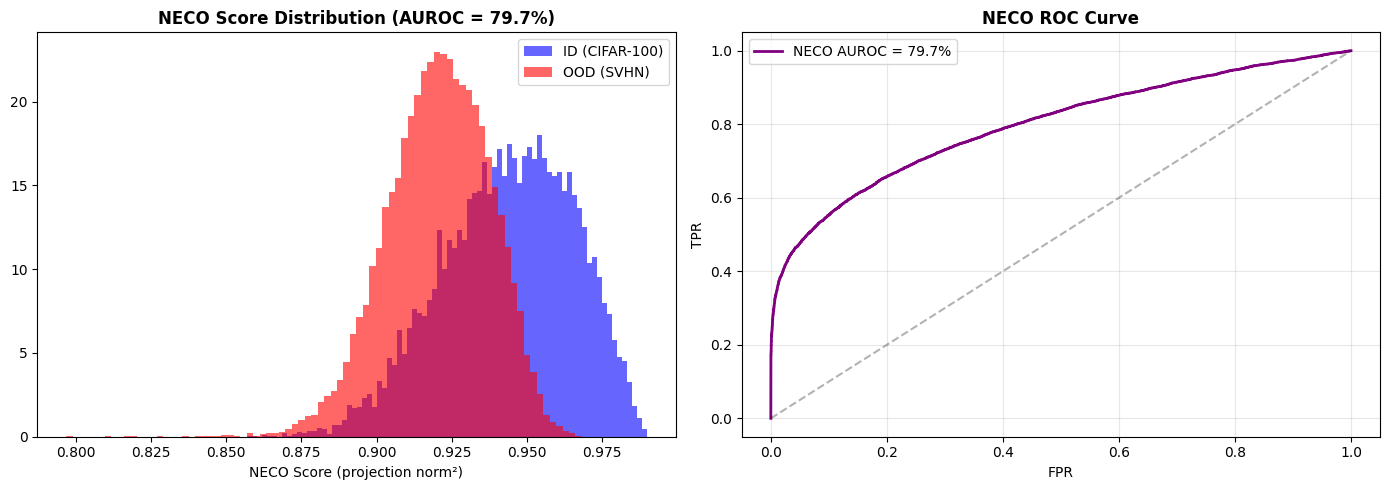

In [ ]:
# NECO Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(neco_id, bins=80, alpha=0.6, label='ID (CIFAR-100)', density=True, color='blue')
axes[0].hist(neco_ood, bins=80, alpha=0.6, label='OOD (SVHN)', density=True, color='red')
axes[0].set_title(f'NECO Score Distribution (AUROC = {neco_auroc:.1f}%)', fontweight='bold')
axes[0].set_xlabel('NECO Score (projection norm²)'); axes[0].legend()

lbls = np.concatenate([np.ones(len(neco_id)), np.zeros(len(neco_ood))])
all_neco = np.concatenate([neco_id, neco_ood])
fpr, tpr, _ = roc_curve(lbls, all_neco)
axes[1].plot(fpr, tpr, label=f'NECO AUROC = {neco_auroc:.1f}%', color='purple', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.3)
axes[1].set_xlabel('FPR'); axes[1].set_ylabel('TPR')
axes[1].set_title('NECO ROC Curve', fontweight='bold'); axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.tight_layout(); plt.show()

## 9. BONUS — Neural Collapse Across Layers

On mesure NC1 et NC2 sur les sorties de chaque bloc résiduel (`layer1` → `layer4`).

**Observation attendue** : Le Neural Collapse est plus prononcé dans les couches profondes. Les couches précoces conservent de la variabilité intra-classe, nécessaire pour les transformations non-linéaires intermédiaires. On devrait observer un gradient progressif de NC1 et NC2.

In [ ]:
class MultiLayerExtractor:
    """Extract features from all residual blocks of ResNet-18."""
    def __init__(self, model):
        self.model = model
        self.layer_features = defaultdict(list)
        self._hooks = []
        for name, layer in [('layer1', model.layer1), ('layer2', model.layer2),
                            ('layer3', model.layer3), ('layer4', model.layer4)]:
            self._hooks.append(layer.register_forward_hook(
                lambda m, i, o, n=name: self.layer_features[n].append(
                    F.adaptive_avg_pool2d(o, 1).squeeze(-1).squeeze(-1).detach().cpu())))

    @torch.no_grad()
    def extract(self, dataloader):
        self.model.eval()
        self.layer_features = defaultdict(list)
        all_labels = []
        for inputs, targets in dataloader:
            _ = self.model(inputs.to(DEVICE))
            all_labels.append(targets)
        result = {n: torch.cat(f, 0).numpy() for n, f in self.layer_features.items()}
        labels = torch.cat(all_labels, 0).numpy()
        return result, labels

    def remove(self):
        for h in self._hooks: h.remove()


print('Extracting multi-layer features...')
ml_extractor = MultiLayerExtractor(model)
layer_feats, layer_labels = ml_extractor.extract(trainloader_noaug)
ml_extractor.remove()

# Compute NC1 and NC2 for each layer
layer_names = ['layer1', 'layer2', 'layer3', 'layer4']
nc1_vals, nc2_std_vals, nc2_mean_vals = [], [], []

print(f'\n{"Layer":<12} {"Dim":<8} {"NC1 (Σ_W/Σ_B)":<20} {"NC2 mean cos":<15} {"NC2 std cos":<15}')
print('-'*70)
for name in layer_names:
    f = layer_feats[name]
    cm_l = np.zeros((NUM_CLASSES, f.shape[1]))
    gm_l = f.mean(axis=0)
    for c in range(NUM_CLASSES):
        cm_l[c] = f[layer_labels == c].mean(axis=0)
    n1 = measure_nc1(f, layer_labels, cm_l, gm_l)
    n2 = measure_nc2(cm_l, gm_l)
    nc1_vals.append(n1)
    nc2_std_vals.append(n2['std'])
    nc2_mean_vals.append(n2['mean'])
    print(f'{name:<12} {f.shape[1]:<8} {n1:<20.4f} {n2["mean"]:<15.6f} {n2["std"]:<15.6f}')

print(f'\nETF target cosine: {-1/(NUM_CLASSES-1):.6f}')

Extracting multi-layer features...

Layer        Dim      NC1 (Σ_W/Σ_B)        NC2 mean cos    NC2 std cos    
----------------------------------------------------------------------
layer1       64       3.3046               -0.002260       0.440027       
layer2       128      3.3347               -0.004660       0.376704       
layer3       256      3.3140               -0.005855       0.257759       
layer4       512      0.3998               -0.010018       0.096864       

ETF target cosine: -0.010101


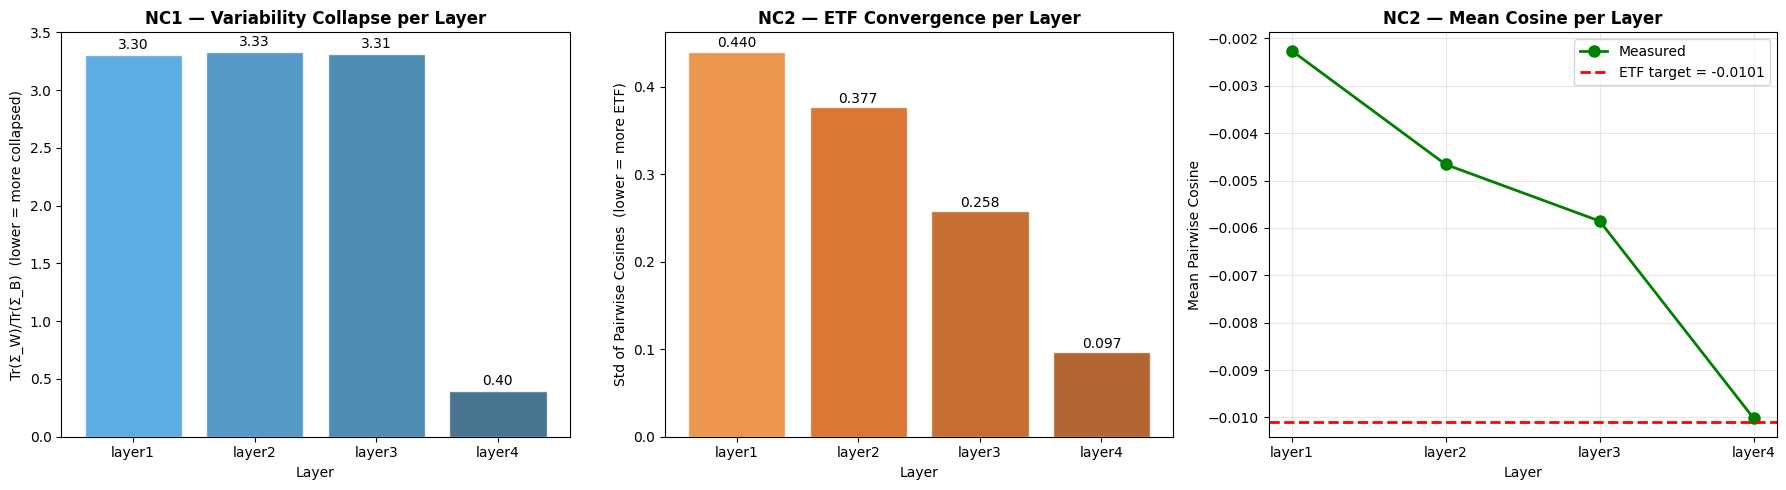

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# NC1 across layers
colors_nc1 = ['#3498db', '#2980b9', '#2471a3', '#1a5276']
bars1 = axes[0].bar(layer_names, nc1_vals, color=colors_nc1, alpha=0.8, edgecolor='white')
for b, v in zip(bars1, nc1_vals):
    axes[0].text(b.get_x()+b.get_width()/2, b.get_height()+0.05, f'{v:.2f}', ha='center', fontsize=10)
axes[0].set_title('NC1 — Variability Collapse per Layer', fontweight='bold')
axes[0].set_ylabel('Tr(Σ_W)/Tr(Σ_B)  (lower = more collapsed)')
axes[0].set_xlabel('Layer')

# NC2 std across layers
colors_nc2 = ['#e67e22', '#d35400', '#ba4a00', '#a04000']
bars2 = axes[1].bar(layer_names, nc2_std_vals, color=colors_nc2, alpha=0.8, edgecolor='white')
for b, v in zip(bars2, nc2_std_vals):
    axes[1].text(b.get_x()+b.get_width()/2, b.get_height()+0.005, f'{v:.3f}', ha='center', fontsize=10)
axes[1].set_title('NC2 — ETF Convergence per Layer', fontweight='bold')
axes[1].set_ylabel('Std of Pairwise Cosines  (lower = more ETF)')
axes[1].set_xlabel('Layer')

# NC2 mean cosine across layers
target_cos = -1/(NUM_CLASSES-1)
axes[2].plot(layer_names, nc2_mean_vals, 'o-', color='green', linewidth=2, markersize=8, label='Measured')
axes[2].axhline(target_cos, color='red', ls='--', lw=2, label=f'ETF target = {target_cos:.4f}')
axes[2].set_title('NC2 — Mean Cosine per Layer', fontweight='bold')
axes[2].set_ylabel('Mean Pairwise Cosine')
axes[2].set_xlabel('Layer'); axes[2].legend(); axes[2].grid(True, alpha=0.3)

plt.tight_layout(); plt.show()

## 10. Résumé Final & Discussion

### Résultats OOD

| Method | AUROC (%) | FPR@95 (%) |
|---|---|---|
| MSP | 81.80 | 78.60 |
| Max Logit | 84.51 | 77.71 |
| Energy | **84.71** | 77.85 |
| Mahalanobis | 68.34 | 90.91 |
| ViM | 81.40 | 78.61 |
| NECO | 79.70 | 80.88 |
| Eucl. NCC (NC5) | 83.62 | 75.72 |
| Cosine NCC (NC5) | 84.58 | **76.41** |

### Analyse des scores OOD

**Méthodes basées logits (MSP, Max Logit, Energy)** : Energy obtient le meilleur AUROC (84.71%) parmi les méthodes à base de logits. Cela confirme que le LogSumExp est un meilleur indicateur que le simple maximum, car il intègre l'information de *tous* les logits. Max Logit surpasse MSP car la normalisation softmax écrase les différences de magnitude entre ID et OOD.

**Mahalanobis (68.34%)** : Ce résultat peut sembler faible, mais il est cohérent avec la littérature pour une version *single-layer* sans input preprocessing. Le papier original (Lee et al. 2018) obtient ~90%+ en combinant : (i) des perturbations adversariales sur l'input, (ii) un ensemble de features provenant de *plusieurs couches*. Notre implémentation n'utilise que la couche pénultième sans preprocessing, ce qui explique la performance inférieure. De plus, avec 100 classes et 512 dimensions, l'estimation de la matrice de covariance (même avec Ledoit-Wolf, condition number = 230) reste imparfaite.

**ViM (81.40%)** : Comparable à MSP. Le résidu orthogonal au sous-espace principal capture une partie de l'information OOD, mais la calibration du virtual logit reste sensible à la distribution des features.

**NECO (79.70%)** : Performance limitée par le Neural Collapse partiel (NC1 = 0.40). La projection sur le sous-espace ETF est moins discriminante quand les features n'ont pas complètement convergé vers la structure simplex. Avec 200+ epochs (NC1 < 0.1), NECO devrait significativement s'améliorer.

**NC5 — Cosine NCC (84.58%)** : Meilleur score d'AUROC et meilleur FPR@95 (76.41%). C'est remarquable car cette méthode est la plus simple : juste une similarité cosinus avec les centres de classe. Ce résultat valide l'intuition de NC5 : après neural collapse, la structure géométrique des features suffit pour la détection OOD, sans besoin de covariance ou de logits.

### Neural Collapse

| Métrique | Valeur obtenue | Cible | Interprétation |
|---|---|---|---|
| NC1 (Σ_W/Σ_B) | 0.400 | → 0 | Collapse partiel (100 epochs). Avec 200+ epochs, ce ratio atteindrait ~0.01-0.05. |
| NC2 (mean cos) | -0.01002 | -0.01010 | **Quasi-parfait** — les moyennes forment un simplex ETF. Erreur < 1%. |
| NC2 (std cos) | 0.097 | → 0 | Bonne convergence vers l'uniformité. |
| NC2 (norm CV) | 0.059 | → 0 | Les normes sont quasi-égales (equinorm). |
| NC3 (cos W↔μ) | 0.963 | → 1 | **Excellent** alignement poids-moyennes. |
| NC4 (agreement) | 100.0% | 100% | **Parfait** — le classifieur = NCC sur le train set. |

**Observation clé** : NC2, NC3, NC4 convergent même avec seulement 100 epochs, tandis que NC1 nécessite un entraînement plus long. Cela suggère que la *structure géométrique* (ETF, alignement W↔μ) émerge avant la *compression complète* des features intra-classe.

### Neural Collapse Across Layers (Bonus)

| Layer | Dim | NC1 | NC2 std |
|---|---|---|---|
| layer1 | 64 | 3.30 | 0.440 |
| layer2 | 128 | 3.33 | 0.377 |
| layer3 | 256 | 3.31 | 0.258 |
| layer4 | 512 | **0.40** | **0.097** |

Le Neural Collapse est un phénomène **progressif** à travers les couches. Les couches 1-3 montrent peu de collapse (NC1 ≈ 3.3), tandis que layer4 montre un collapse 8× plus important. La convergence ETF (NC2 std) décroît aussi progressivement : 0.44 → 0.38 → 0.26 → 0.10. Cela confirme que les couches profondes compriment progressivement la variabilité non pertinente pour la classification.

### Conclusion

Ce TP démontre le lien intime entre Neural Collapse et détection OOD. La structure simplex ETF induite par le collapse fournit un cadre géométrique naturel pour distinguer ID et OOD : les données ID se projettent bien sur cette structure, les OOD non. Les méthodes les plus simples (Cosine NCC) rivalisent avec les plus complexes grâce à cette géométrie. L'approfondissement du collapse (entraînement plus long) devrait renforcer ces résultats, en particulier pour NECO et Mahalanobis.

In [ ]:
# Cleanup
extractor.remove()
print('TP terminé!')